# 无监督聚类和类型注释

细胞类型注释根据不同细胞群的表达标记，和已知的细胞特征进行比较，判断细胞的身份

In [ ]:
%load_ext autoreload
%autoreload 2

In [52]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

In [53]:
expm = em.load_experiment('expression', load_samples = False)

[!] samples are not dumped in the experiment directory.


In [54]:
print(expm)

annotated data of size 13418 × 19665
integrated dataset of size 13418 × 19665
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32>
   obsm : harmony <arr:f64(35)> knn <arr:i32(100)> knn.d <arr:f32(100)> knn.d.nn.scvi <arr:f32(50)>
          knn.nn.scvi <arr:i32(50)> pca <arr:f64(35)> scvi <arr:f32(30)> umap <arr:f32(2)>
   varm : pca <arr:f64(35)>
   obsp : connectivities <csr:f32> connectivities.nn.scvi <cs

### 观察降维形式

对于大多数合理的细胞注释，它必须基于一个合理的聚类结果。 软件包实现了一些常用的聚类方式

#### Leiden 聚类

Leiden 算法无监督的给出层次聚类

In [55]:
expm.run_rna_leiden(
    resolution = 0.8,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

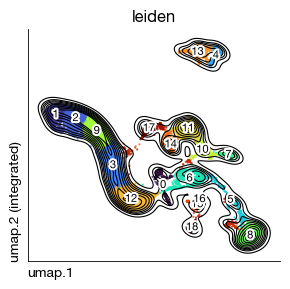

In [59]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'leiden',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

#### SC3 聚类

SC3 给出了一种基于 k-均值聚类的无监督聚类，需要事先指定期望的聚类数目

In [ ]:
expm.run_rna_sc3(
    basis = 'harmony',
    key_added = 'sc3',
    n_clusters = [5, 10, 20, 30],
    d_range = None,
    n_runs = 5,
    n_facility = None,
    multiplier_facility = None,
    batch_size = None,
    random_state = 42
)

[i] multiplier_facility not set, using default value of 3
[i] number of facilities calculated as 90


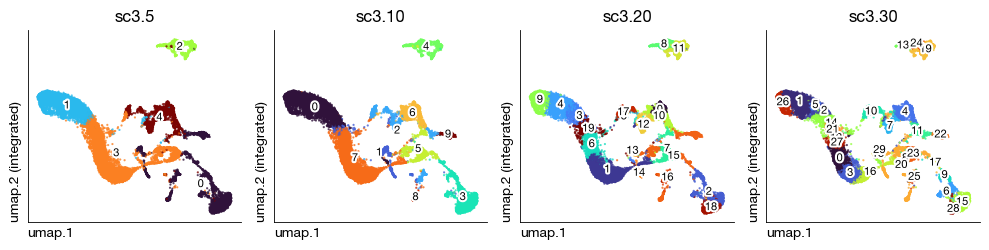

In [ ]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['sc3.5', 'sc3.10', 'sc3.20', 'sc3.30'], ncols = 4,
    figsize = (10, 2.6), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8
)

#### NMF 聚类

NMF 通过分解正矩阵得到标记分解

In [61]:
# nmf requires linear normalized data
expm['rna'].layers['norm'] = em.np.expm1(expm['rna'].X)

In [62]:
expm.run_rna_consensus_nmf(
    counts = 'counts', tpm = 'norm', ks = [5, 10, 15, 20],
    hvg = 'vst.all.hvg', ncpus = 50, key_added = 'cnmf', min_counts = 0
)

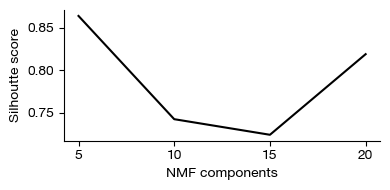

In [63]:
fig = expm.plot_rna_cnmf_silhoutte(figsize = (4, 2))

In [65]:
expm.run_rna_consensus_nmf_extract_k(k = 10)

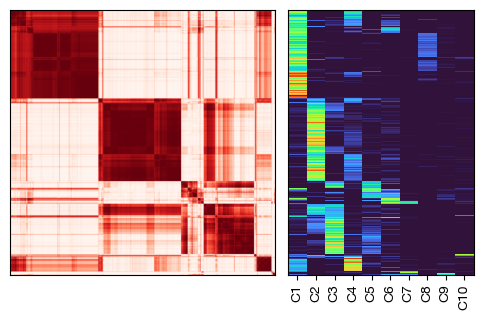

In [80]:
fig = expm.plot_rna_cnmf_distance_usages(
    k = 10, downsample = 0.1, method = 'complete', cmap = 'reds',
    cmap_annotations = 'turbo', annotations = 'cnmf.10', metrics = 'cosine',
    legend_cols = 1, figsize = (7, 3.3)
)

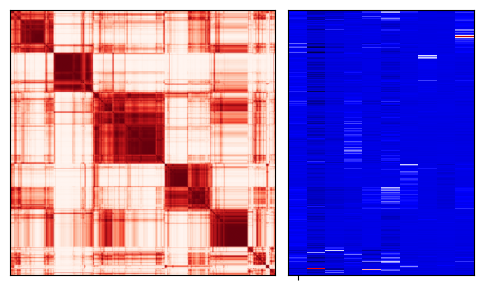

In [81]:
fig = expm.plot_rna_cnmf_distance_modules(
    k = 10, downsample = 1, method = 'complete', cmap = 'reds',
    cmap_annotations = 'seismic', annotations = 'cnmf.coef.10', metrics = 'cosine',
    legend_cols = 1, figsize = (5, 3)
)

### 操作和选择聚类

我们通过选择和排除聚类得到我们想要的合适子集

In [83]:
expm.save()

[i] main dataset write to expression/integrated.h5mu


In [82]:
expm.build_subset(
    subset_name = 'mono-neutro',
    slot = 'rna',
    keys = ['leiden'],
    values = [['1', '2', '9', '3', '12', '6', '7', '10', '11', '14', '17', '15', '16', '18']]
)

[i] selected 10405 observations from 13418.


### 手动注释

直接使用基因标记，手动整理聚类结果并给出标签；对于知识充分的模型（例如小鼠骨髓细胞群）这是最方便的

In [84]:
expm = em.load_experiment('expression', load_samples = False, load_subset = 'mono-neutro')

[!] samples are not dumped in the experiment directory.


In [85]:
print(expm)

annotated data of size 10405 × 19665
subset mono-neutro of size 10405 × 19665
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32> norm <f32>
   obsm : cnmf.10 <df> harmony <arr:f64(35)> knn <arr:i32(100)> knn.d <arr:f32(100)>
          knn.d.nn.scvi <arr:f32(50)> knn.nn.scvi <arr:i32(50)> pca <arr:f64(35)> scvi <arr:f32(30)>
          umap <arr:f32(2)>
   varm : cnmf.10 <arr:f64(10)> cnmf.coef.10 <arr:f64(1

In [102]:
expm.run_rna_knn(
    use_rep = 'harmony',
    n_comps = None,
    n_neighbors = 100,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [103]:
expm.run_rna_umap(
    min_dist = 0.4,
    spread = 0.9,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

In [104]:
expm.run_rna_leiden(
    resolution = 1,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

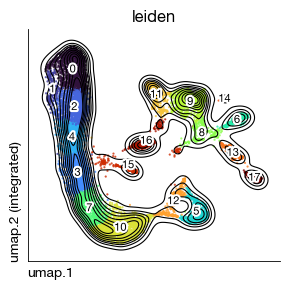

In [100]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'leiden',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

移除可疑的双细胞，注意在删除样本之后，kNN 图会被破坏，需要重新运行 kNN

In [ ]:
expm.exclude(
    slot = 'rna',
    annotation = 'leiden',
    remove = ['15']
)

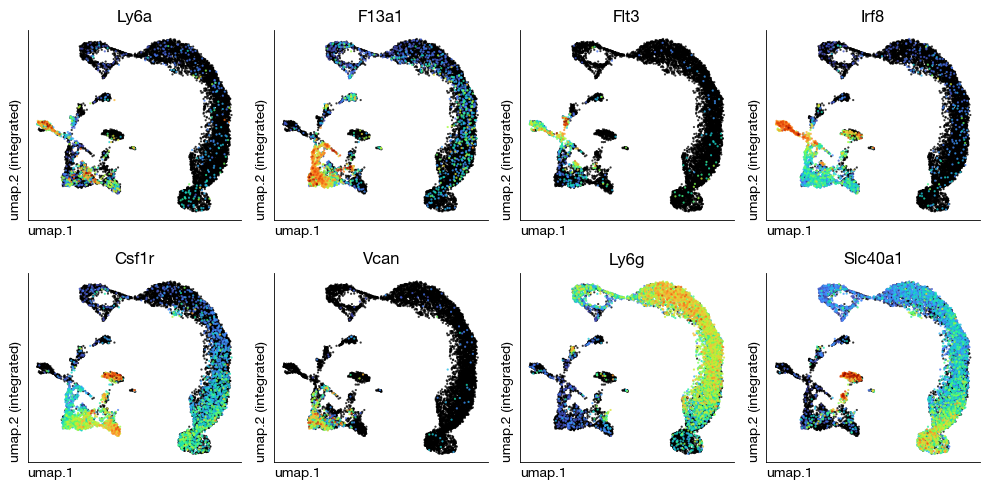

In [105]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = [
        'Ly6a', 'F13a1', 'Flt3', 'Irf8',
        'Csf1r', 'Vcan', 'Ly6g', 'Slc40a1'
    ], ncols = 4,
    sort = True, figsize = (10, 5), dpi = 100, legend = False, 
    annotate_style = 'text', annotate_fontsize = 8, ptsize = 2
)

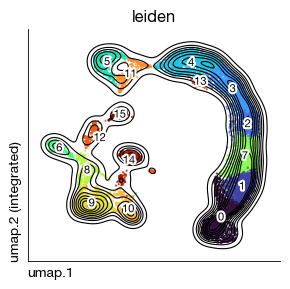

In [106]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'leiden',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

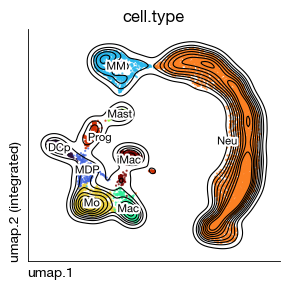

In [140]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'cell.type',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

In [ ]:
expm.annotate(
    slot = 'rna',
    annotation = 'cell.type',
    cluster = 'leiden',
    mapping = {
        'Prog': [12],
        'DCp': [6],
        'MDP': [8],
        'Mo': [9],
        'Mac': [10],
        'iMac': [14],
        'MM': [5, 11],
        'Neu': [4, 13, 3, 2, 7, 1, 0],
        'Mast': [15]
    }
)

我们可以为每个类群获取标记基因

In [133]:
expm.run_rna_markers(
    groupby = 'cell.type',
    mask_var = None,
    groups = 'all',
    reference = 'rest',
    n_genes = None, rankby_abs = False, pts = True,
    key_added = 'markers',
    method = 't-test',
    corr_method = 'benjamini-hochberg',
    tie_correct = False,
    gene_symbol = 'gene',
    layer = 'X'
)

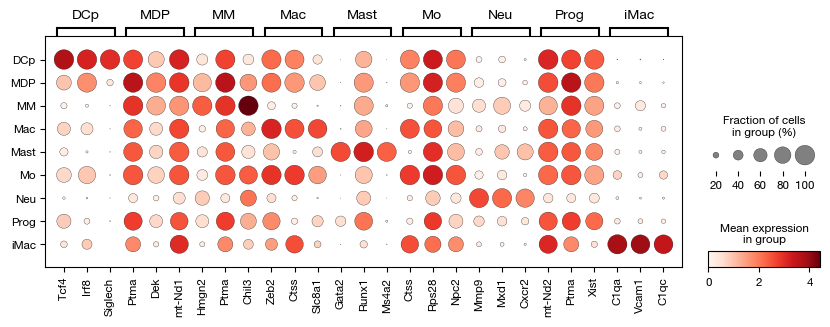

In [134]:
fig = expm.plot_rna_markers(
    groups = None,
    n_genes = 3,
    groupby = 'cell.type',
    values_to_plot = None,
    var_names = None,
    min_logfoldchange = 1,
    max_logfoldchange = None,
    max_p_adjust = 0.05,
    min_pct = 0.25,
    max_pct_reference = 0.75,
    key = 'markers',
    gene_symbols = 'gene',
    figsize = (10, 3),
    dpi = 100,
    plot_type = 'dotplot'
)

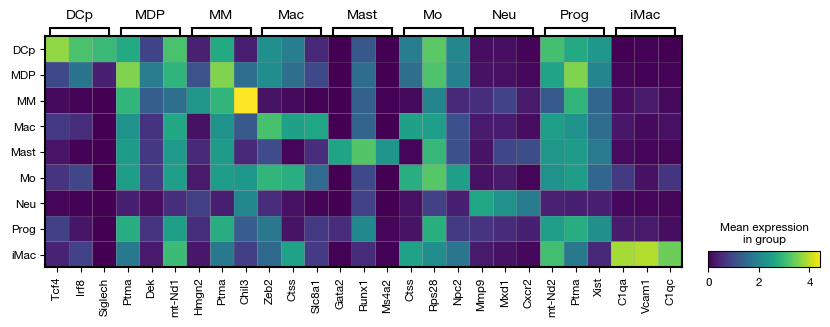

In [135]:
fig = expm.plot_rna_markers(
    groups = None,
    n_genes = 3,
    groupby = 'cell.type',
    values_to_plot = None,
    var_names = None,
    min_logfoldchange = 1,
    max_logfoldchange = None,
    max_p_adjust = 0.05,
    min_pct = 0.25,
    max_pct_reference = 0.75,
    key = 'markers',
    gene_symbols = 'gene',
    figsize = (10, 3),
    dpi = 100,
    plot_type = 'matrixplot'
)

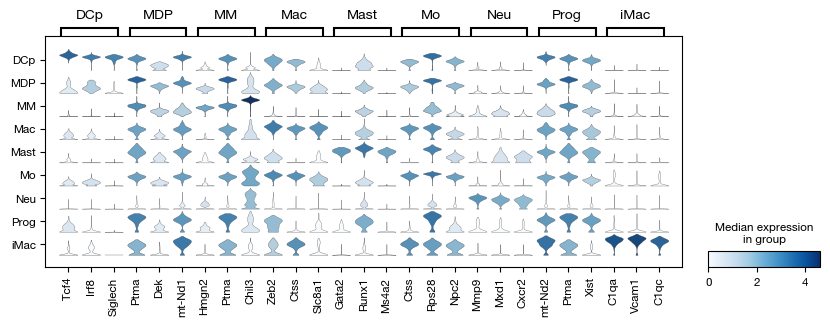

In [136]:
fig = expm.plot_rna_markers(
    groups = None,
    n_genes = 3,
    groupby = 'cell.type',
    values_to_plot = None,
    var_names = None,
    min_logfoldchange = 1,
    max_logfoldchange = None,
    max_p_adjust = 0.05,
    min_pct = 0.25,
    max_pct_reference = 0.75,
    key = 'markers',
    gene_symbols = 'gene',
    figsize = (10, 3),
    dpi = 100,
    plot_type = 'stacked_violin'
)

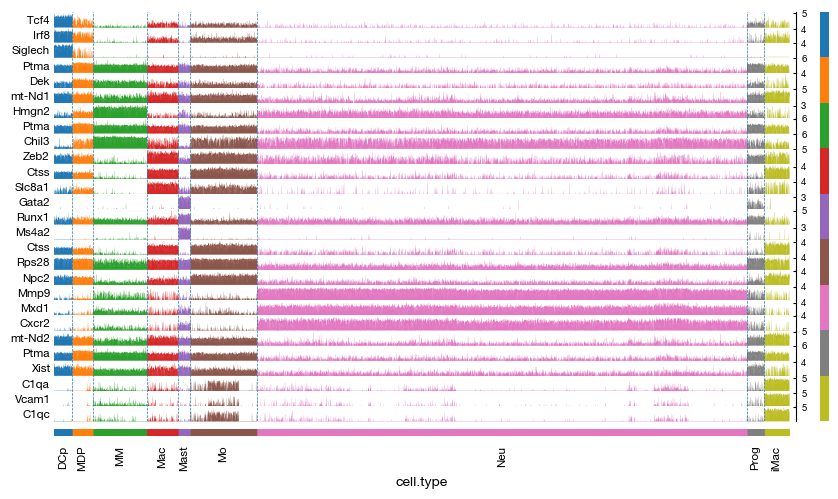

In [137]:
fig = expm.plot_rna_markers(
    groups = None,
    n_genes = 3,
    groupby = 'cell.type',
    values_to_plot = None,
    var_names = None,
    min_logfoldchange = 1,
    max_logfoldchange = None,
    max_p_adjust = 0.05,
    min_pct = 0.25,
    max_pct_reference = 0.75,
    key = 'markers',
    gene_symbols = 'gene',
    figsize = (10, 5.5),
    dpi = 100,
    plot_type = 'tracksplot'
)

### 观察细胞比例

软件包提供了一些函数来快速计算细胞类型占比

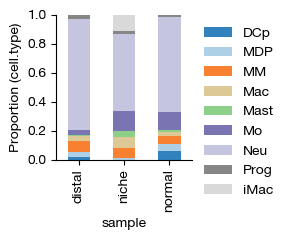

In [144]:
fig = expm.plot_rna_proportion(
    major = 'sample', minor = 'cell.type', plot = 'bar', cmap = 'category20c',
    normalize = 'index', figsize = (3, 2.5), stacked = True, legend = True
)

In [147]:
expm.run_rna_proportion(
    major = 'sample', minor = 'cell.type',
    normalize = 'index'
)

cell.type,DCp,MDP,MM,Mac,Mast,Mo,Neu,Prog,iMac
sample,,,,,,,,,
distal,0.019303,0.030619,0.082316,0.031507,0.004438,0.037719,0.76592,0.027069,0.001109
niche,0.001337,0.009696,0.072551,0.074557,0.039786,0.138081,0.52658,0.026078,0.111334
normal,0.062359,0.044703,0.057851,0.026672,0.009767,0.126597,0.65402,0.015026,0.003005


### 保存数据集

保存我们作出的更改

In [138]:
expm.save()

[i] main dataset write to expression/subsets/mono-neutro.h5mu
